# **Importing the Necessary Libraries**

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.decomposition import PCA







# **DATASET LOADING**

In [5]:
file_path = 'Crop_recommendation.csv'

df = pd.read_csv(file_path)

# Display the first 5 rows to verify
print(df.head())

    N   P   K  temperature   humidity        ph    rainfall label
0  90  42  43    20.879744  82.002744  6.502985  202.935536  rice
1  85  58  41    21.770462  80.319644  7.038096  226.655537  rice
2  60  55  44    23.004459  82.320763  7.840207  263.964248  rice
3  74  35  40    26.491096  80.158363  6.980401  242.864034  rice
4  78  42  42    20.130175  81.604873  7.628473  262.717340  rice


# **PREPROCESSING**

### **Handling Missing Values**

In [6]:
print("Missing values per column:")
print(df.isnull().sum())

# Drop missing rows
df = df.dropna()
print("After removing missing values:", df.shape)


Missing values per column:
N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64
After removing missing values: (2200, 8)


In [7]:
print("Duplicate rows:", df.duplicated().sum())

df = df.drop_duplicates()
print("After removing duplicates:", df.shape)


Duplicate rows: 0
After removing duplicates: (2200, 8)


In [8]:
feature_ranges = {
    'N': (0, 140),           # Nitrogen
    'P': (0, 140),           # Phosphorus
    'K': (0, 205),           # Potassium
    'temperature': (10, 50), # Celsius
    'humidity': (10, 100),   # %
    'ph': (3.5, 9),          # soil pH
    'rainfall': (0, 500)     # mm
}

for col, (min_val, max_val) in feature_ranges.items():
    before = df.shape[0]
    df = df[(df[col] >= min_val) & (df[col] <= max_val)]
    after = df.shape[0]
    print(f"{col}: removed {before-after} rows outside realistic range")

print("After removing unrealistic values:", df.shape)


N: removed 0 rows outside realistic range
P: removed 44 rows outside realistic range
K: removed 0 rows outside realistic range
temperature: removed 4 rows outside realistic range
humidity: removed 0 rows outside realistic range
ph: removed 11 rows outside realistic range
rainfall: removed 0 rows outside realistic range
After removing unrealistic values: (2141, 8)


### **Outliner Removal**

In [9]:
numeric_cols = ['N','P','K','temperature','humidity','ph','rainfall']

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    before = df.shape[0]
    df = df[(df[col] >= lower) & (df[col] <= upper)]
    after = df.shape[0]
    print(f"{col}: removed {before-after} outlier rows")

print("After outlier removal:", df.shape)


N: removed 0 outlier rows
P: removed 97 outlier rows
K: removed 55 outlier rows
temperature: removed 58 outlier rows
humidity: removed 0 outlier rows
ph: removed 48 outlier rows
rainfall: removed 39 outlier rows
After outlier removal: (1844, 8)


### **Encoding Label**

In [10]:
le = LabelEncoder()
df['label_reduced'] = df['label'] # Create 'label_reduced' from the original 'label' column
df['label_encoded'] = le.fit_transform(df['label_reduced'])

print("Encoded classes:", list(le.classes_))
df.head()

Encoded classes: ['banana', 'blackgram', 'chickpea', 'coconut', 'coffee', 'cotton', 'jute', 'kidneybeans', 'lentil', 'maize', 'mango', 'mothbeans', 'mungbean', 'muskmelon', 'orange', 'papaya', 'pigeonpeas', 'pomegranate', 'rice', 'watermelon']


,N,P,K,temperature,humidity,ph,rainfall,label,label_reduced,label_encoded
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice,rice,18
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice,rice,18
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice,rice,18
7,94,53,40,20.277744,82.894086,5.718627,241.974195,rice,rice,18
8,89,54,38,24.515881,83.535216,6.685346,230.446236,rice,rice,18


In [11]:
df = df.drop(columns=['label', 'label_reduced'])

print("Final dataset shape:", df.shape)
df.head()


Final dataset shape: (1844, 8)


,N,P,K,temperature,humidity,ph,rainfall,label_encoded
0,90,42,43,20.879744,82.002744,6.502985,202.935536,18
1,85,58,41,21.770462,80.319644,7.038096,226.655537,18
3,74,35,40,26.491096,80.158363,6.980401,242.864034,18
7,94,53,40,20.277744,82.894086,5.718627,241.974195,18
8,89,54,38,24.515881,83.535216,6.685346,230.446236,18


In [12]:
df.to_csv("Crop_Recommendation_Cleaned_Encoded.csv", index=False)
print("Dataset cleaned, reduced, encoded, and saved!")


Dataset cleaned, reduced, encoded, and saved!


In [13]:
X = df.iloc[:,0:-1].values
y = df.iloc[:,-1].values

In [14]:
X

array([[ 90.        ,  42.        ,  43.        , ...,  82.00274423,
          6.50298529, 202.9355362 ],
       [ 85.        ,  58.        ,  41.        , ...,  80.31964408,
          7.03809636, 226.6555374 ],
       [ 74.        ,  35.        ,  40.        , ...,  80.15836264,
          6.9804009 , 242.8640342 ],
       ...,
       [118.        ,  33.        ,  30.        , ...,  67.22512329,
          6.36260785, 173.3228386 ],
       [117.        ,  32.        ,  34.        , ...,  52.12739421,
          6.75879255, 127.1752928 ],
       [104.        ,  18.        ,  30.        , ...,  60.39647474,
          6.77983261, 140.9370415 ]], shape=(1844, 7))

In [15]:
y

array([18, 18, 18, ...,  4,  4,  4], shape=(1844,))

### **Train-test split**

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [17]:
X_train

array([[ 58.        ,  61.        ,  15.        , ...,  64.23364112,
          7.40289167,  62.78730907],
       [ 89.        ,  85.        ,  55.        , ...,  76.48541655,
          6.27538461,  91.73358569],
       [  7.        ,  63.        ,  24.        , ...,  64.45268309,
          6.81868109,  53.04669416],
       ...,
       [ 74.        ,  40.        ,  40.        , ...,  83.12053888,
          6.38625998, 169.3388465 ],
       [ 17.        ,  58.        ,  20.        , ...,  85.91625451,
          6.42937879,  39.23831035],
       [ 47.        ,  63.        ,  16.        , ...,  67.10464369,
          6.661871  ,  72.50669768]], shape=(1475, 7))

In [18]:
X_test

array([[ 88.        ,  17.        ,  52.        , ...,  90.75284363,
          6.64696242,  25.37828397],
       [ 41.        ,  69.        ,  82.        , ...,  16.63294455,
          6.71558723,  68.97806542],
       [ 34.        ,  60.        ,  23.        , ...,  24.96969858,
          5.65925498, 100.0497183 ],
       ...,
       [102.        ,  37.        ,  25.        , ...,  77.91757121,
          5.9079309 ,  72.82902109],
       [ 83.        ,   9.        ,  45.        , ...,  89.13163965,
          6.04960989,  46.85176955],
       [ 83.        ,  38.        ,  35.        , ...,  52.88667115,
          7.18915558, 136.7325092 ]], shape=(369, 7))

In [19]:
y_train

array([ 1,  0,  8, ...,  6, 12,  1], shape=(1475,))

In [20]:
y_test

array([13,  2,  7, 12,  1, 18,  2, 11,  4, 10, 19,  3,  8, 13,  0,  5, 14,
       19,  2, 18,  4, 13, 10, 19, 12,  8, 19,  4,  5, 13,  6,  5, 16,  9,
       15, 19, 18,  4,  7,  2,  9,  9,  3, 10, 19, 10, 17, 11,  5, 17,  3,
        2, 13, 18, 13, 14, 18, 12,  2, 17, 13, 12, 15, 18,  7,  4, 12,  6,
       12,  5,  0,  2,  9, 11,  9, 12, 11, 13,  3,  3,  9,  5,  4, 13, 12,
        0, 10,  2,  5,  6,  8,  0,  2,  0, 17,  3, 19,  6,  4, 13, 14,  0,
        6,  9, 10, 12, 16,  8,  9,  7,  5, 10,  3,  7,  7, 10, 10, 13,  9,
       14, 16, 13,  9, 15,  8, 10, 18,  9,  5,  7,  8, 15, 17,  3, 17,  7,
        6,  6, 15, 15,  5, 10, 12, 18, 10, 16,  6, 19, 19, 15,  5,  7,  1,
        2, 10, 17,  8,  3, 17,  8,  0, 18,  4, 19, 14,  6, 11, 15,  9, 15,
        8,  1, 13,  1, 14, 12,  8,  4, 13,  9, 11,  2,  4,  4, 18,  7, 14,
       16, 12,  5, 19, 16, 12, 10,  0, 18, 16,  8, 17,  6, 15,  8, 13, 18,
        4, 14, 12,  2,  9, 17,  6, 11, 15,  2, 10, 17,  6, 16, 18, 18, 13,
        5, 17, 12,  5,  4

### **Feature Scaling**

In [21]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)

In [22]:
X_train

array([[ 0.1121623 ,  0.70957828, -1.07139809, ..., -0.23324951,
         1.35769714, -0.7550671 ],
       [ 0.928172  ,  1.7672679 ,  1.34562815, ...,  0.30570879,
        -0.29505601, -0.19249683],
       [-1.23030528,  0.79771908, -0.52756719, ..., -0.22361381,
         0.50133366, -0.94437575],
       ...,
       [ 0.53332859, -0.21590015,  0.43924331, ...,  0.59758929,
        -0.13252965,  1.31575977],
       [-0.96707634,  0.57736707, -0.76926981, ...,  0.72057344,
        -0.06932405, -1.2127414 ],
       [-0.17738953,  0.79771908, -1.01097243, ..., -0.10695347,
         0.27147402, -0.56617099]], shape=(1475, 7))

In [23]:
model = LogisticRegression(random_state = 0)

In [24]:
model.fit(X_train, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",0
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`multic

# **MODEL EVALUATION**

In [25]:
y_pred = model.predict(sc.transform(X_test))

In [26]:
y_pred

array([13,  2,  7, 12,  1, 18,  2, 11,  4, 10, 19,  3,  8, 13,  0,  5, 14,
       19,  2,  6,  4, 13, 10, 19, 12,  8, 19,  4,  5, 13,  6,  5, 16,  9,
       18, 19, 18,  4,  7,  2,  9,  9,  3, 10, 19, 10, 17, 11,  5, 17,  3,
        2, 13, 18, 13, 14,  6, 12,  2, 17, 13, 12, 15, 18,  7,  4, 12,  6,
       12,  5,  0,  2,  9, 11,  9, 12, 11, 13,  3,  3,  9,  5,  4, 13, 12,
        0, 10,  2,  5,  6,  8,  0,  2,  0, 17,  3, 19,  6,  4, 13, 14,  0,
        6,  9, 10, 12, 16,  8,  9,  7,  5, 10,  3,  7,  7, 10, 10, 13,  9,
       14,  7, 13,  9, 15,  8, 10,  6,  9,  5,  7,  8, 15, 17,  3, 17,  7,
        6,  6, 15, 15,  5, 10, 12, 18, 10, 16,  6, 19, 19, 15,  5,  7,  1,
        2, 10, 17,  8,  3, 17,  8,  0,  6,  4, 19, 14, 18, 11, 15,  9, 15,
        8,  1, 13,  1, 14, 12,  8,  4, 13,  9, 11,  2,  4,  4, 18,  7, 14,
       16, 12,  5, 19, 16, 12, 10,  0, 18, 16,  8, 17,  6, 15,  8, 13, 18,
        4, 14, 12,  2,  9, 17,  6, 11, 15,  2, 10, 17,  6, 16, 18, 18, 13,
        5, 17, 12,  5,  4

In [27]:
model.predict(sc.transform([[5,62,23,27.93,66.45,4.72,145.37]]))

array([16])

### **Confusion Matrix**

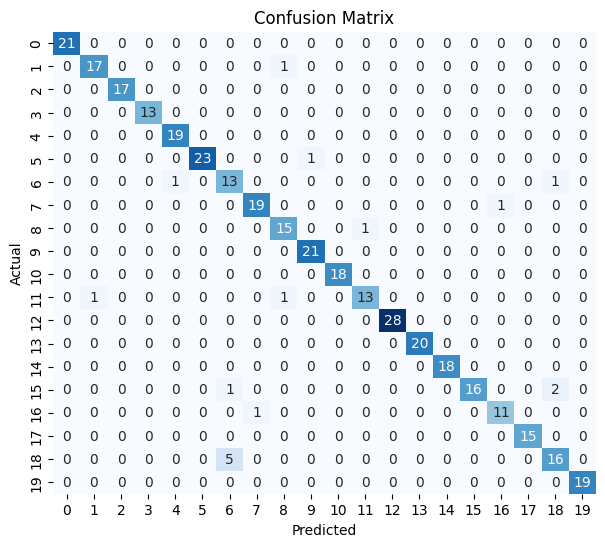

In [28]:
confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### **Accuracy**

In [29]:
accuracy = accuracy_score(y_test,y_pred)
print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))

Accuracy: 0.9539


### **Precision, Recall, F1-score**

In [30]:
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Precision:", round(precision, 4))
print("Recall:", round(recall, 4))
print("F1-score:", round(f1, 4))

Precision: 0.9569
Recall: 0.9539
F1-score: 0.9543


### **ROC Curve**

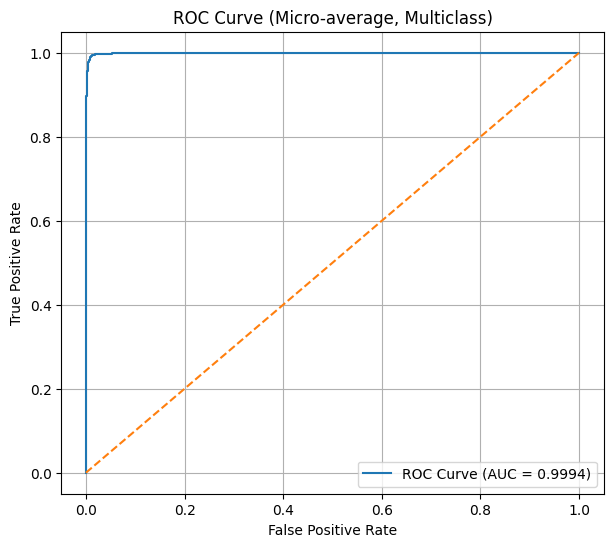

In [31]:
# Predict probabilities
y_prob = model.predict_proba(sc.transform(X_test))
# Convert label-encoded y_test to binary format
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_prob.ravel())
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Micro-average, Multiclass)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# **VISUALIZATIONS**

### **Correlation Heatmap**

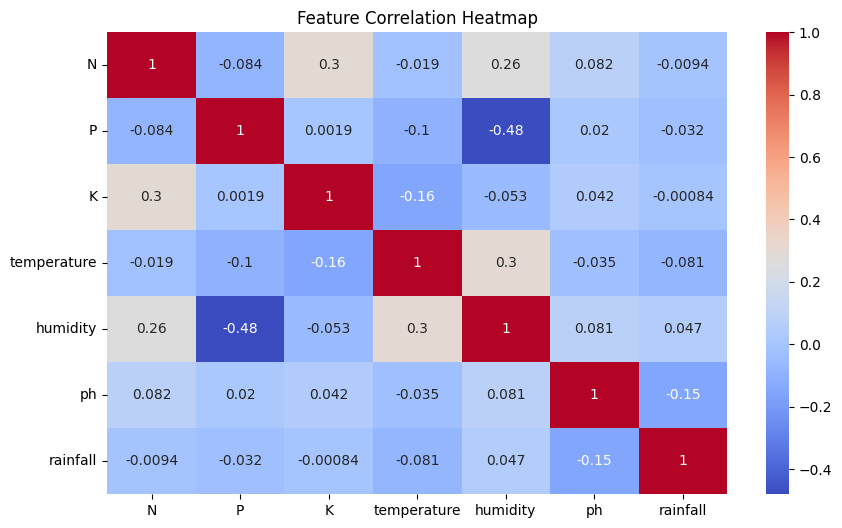

In [32]:
plt.figure(figsize=(10,6))
sns.heatmap(df.drop(columns=['label_encoded']).corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

### **PCA Scatter Plot**

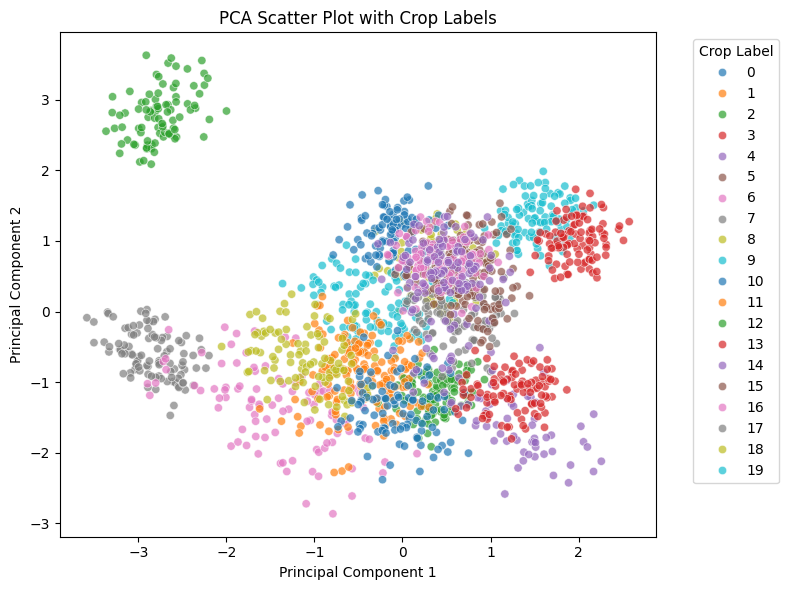

In [33]:
# Separate features and label
X = df.drop(columns=['label_encoded']) # Drop label_encoded for features
y = df['label_encoded']   # Use label_encoded as the target

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create PCA DataFrame
pca_df = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'Label': y
})

# Plot PCA scatter with label
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=pca_df,
    x='PC1',
    y='PC2',
    hue='Label',
    palette='tab10',
    alpha=0.7
)

plt.title('PCA Scatter Plot with Crop Labels')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Crop Label', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### **Box Plot**

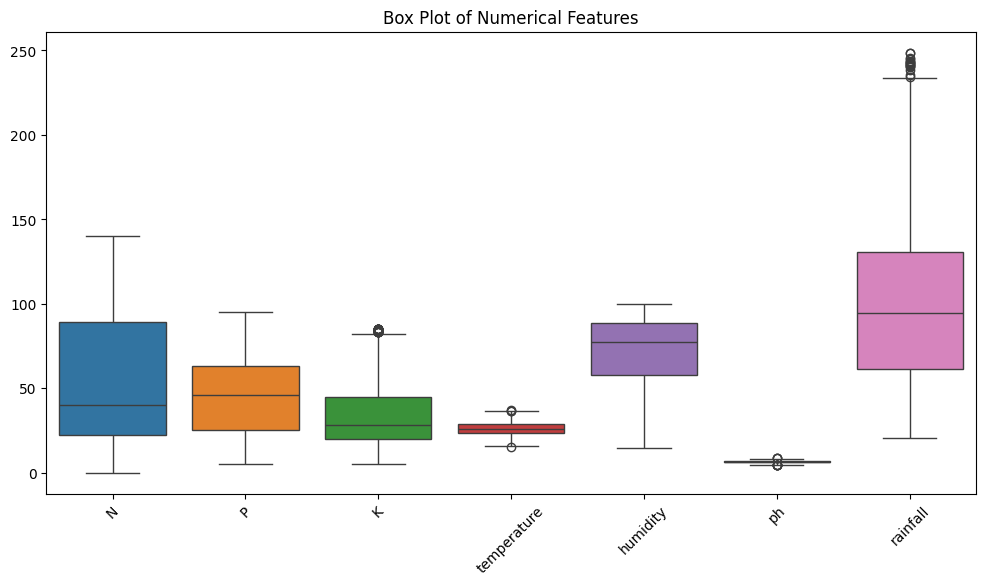

In [34]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df.drop(columns=['label_encoded']))
plt.title("Box Plot of Numerical Features")
plt.xticks(rotation=45)
plt.show()

# **INSIGHTS**

### **Model Performance**


- The Logistic Regression model demonstrates excellent performance for this multi-class problem, achieving an Accuracy of 95.39 and a near-perfect Micro-average AUC of 0.9994. All major classification metrics (Precision, Recall, F1-score) are consistently high at 0.95, indicating reliable and balanced predictive power across the approx 20 crop classes.

### **Feature behavior**

- The features exhibit clear patterns, including a strong positive correlation between temperature and humidity (0.686), while other features like rainfall show a wide distribution and many outliers. Crucially, the PCA plot confirms the strong discriminatory power of the scaled features, as the crop classes are visually well-separated in the reduced feature space.

### **Interpretation of Results**

- The exceptional performance confirms the Logistic Regression model is highly effective for crop recommendation, suggesting the relationship between the soil and weather features and the optimal crop is highly linear and distinct. While the results suggest high reliability, the extremely high metrics raise a potential concern for overfitting, meaning the model might not generalize as well to new data, and further validation is necessary.

### **Improvement suggestions**

- Future work should focus on robust validation by implementing k-fold cross-validation and systematically performing hyperparameter tuning on the current model. It is also recommended to test advanced models (like Random Forest or XGBoost) for comparison, and specifically address the high variance and outliers in the rainfall feature by applying a suitable transformation before scaling.